## Project definition:
The goal of this project is to develop a machine learning model that can accurately classify brain stroke from MRI images and predict the severity of the stroke using National Institutes of Health Stroke Scale (NIHSS) and Magnetic Resonance Spectroscopy (MRS) data obtained from the same images.

The project will involve collecting a dataset of MRI images from patients with and without stroke. The MRI images will be preprocessed to extract relevant features using techniques such as image registration, segmentation, and feature extraction.

The extracted features will then be used to train a machine learning model using classification algorithms such as convolutional neural networks (CNN) and support vector machines (SVM). The trained model will be evaluated using standard metrics such as accuracy, sensitivity, and specificity.

In addition to stroke classification, the project will also involve predicting the severity of the stroke using NIHSS and MRS data extracted from the MRI images. This will involve using regression techniques such as linear regression and decision trees to predict the severity of the stroke based on the extracted data.

The final product of this project will be a machine learning model that can accurately classify stroke from MRI images and predict the severity of the stroke using NIHSS and MRS data. This model can be used by radiologists and neurologists to assist in the diagnosis and treatment of stroke patients.

In [2]:
! pip install pydicom
! pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import random
import numpy as np
import pandas as pd
import pydicom
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set the path to your .dcm image folder
dir_path = "/content/drive/MyDrive/MRI-dataset"
csv_path = "/content/drive/MyDrive/MRI-dataset/labels.csv"

In [6]:
# Set the target image size
img_size = (256, 256)

In [21]:
# Load the labels from the CSV file into a pandas DataFrame
labels_df = pd.read_csv(csv_path)
# Replace missing NIHSS scores with the median value
median_nihss = labels_df['nihss'].median()
labels_df['nihss'].fillna(median_nihss, inplace=True)

# Replace missing MRS scores with the mode value
mode_mrs = labels_df['mrs'].mode()[0]
labels_df['mrs'].fillna(mode_mrs, inplace=True)


In [22]:
labels_df

,ID,stroke_type,nihss,mrs
0,2 (1),Ischemic,2.0,0.0
1,2 (2),Ischemic,4.0,2.0
2,2 (3),Ischemic,4.0,2.0
3,2 (4),Ischemic,4.0,2.0
4,2 (5),Ischemic,4.0,2.0
...,...,...,...,...
606,110 (5),Ischemic,2.0,0.0
607,110 (6),Ischemic,2.0,0.0
608,110 (7),Ischemic,2.0,0.0
609,111 (1),Ischemic,0.0,0.0


In [23]:
# Create a dictionary to map stroke types to integer labels
stroke_type_map = {'Ischemic': 0, 'Hemorrhagic': 1, 'TIA': 2}

# Create an empty list to store the image data and labels
data = []
labels = []

In [24]:
from threading import excepthook
# Loop over the DICOM files and their corresponding labels
for filename in os.listdir(dir_path):
    if filename.endswith('.dcm'):
        # Load the DICOM file
        dcm_path = os.path.join(dir_path, filename)
        dcm = pydicom.read_file(dcm_path)
        
        # Preprocess the image by resizing and normalizing
        img = dcm.pixel_array
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, img_size)
        
        # Extract the corresponding labels from the CSV file
        patient_id = filename[:-4]
        try:
          stroke_type = labels_df[labels_df['ID'] == patient_id]['stroke_type'].values[0]
          nihss = labels_df[labels_df['ID'] == patient_id]['nihss'].values[0]
          mrs = labels_df[labels_df['ID'] == patient_id]['mrs'].values[0]
        except:
          print(patient_id)
        
        # Convert the stroke type to an integer label
        stroke_type_label = stroke_type_map[stroke_type]
        
        # Add the image and labels to the data and labels lists
        data.append(img)
        labels.append([stroke_type_label, nihss, mrs])

35 (1)
35 (2)
35 (4)
35 (3)
35 (5)
35 (6)
22 (15)
22 (16)
22 (17)
22 (18)
22 (19)
22 (20)
22 (21)
22 (22)
22 (23)
22 (24)
22 (25)
22 (11)
22 (12)
22 (13)
22 (14)
12 (10)


In [25]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [26]:
# Convert the stroke type labels to one-hot encoding
one_hot_labels = to_categorical(labels[:, 0], num_classes=3)

# Combine the one-hot encoded labels with the NIHSS and MRS scores
labels = np.concatenate([one_hot_labels, labels[:, 1:]], axis=1)


In [27]:
# Define an augmentation generator for the images
aug_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [28]:
# Split the data and labels into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [29]:
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

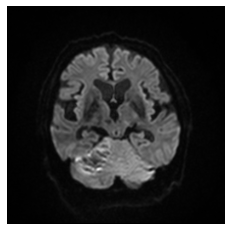

In [30]:
image = data[0]
show_image(image)

In [31]:
# Define the input shape of the model
input_shape = img_size + (1,)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])



In [32]:
# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the training data and use the augmentation generator for data augmentation
history = model.fit(aug_generator.flow(train_data, train_labels, batch_size=32), 
                    validation_data=(test_data, test_labels),
                    epochs=3, verbose=1)

Epoch 1/3
8/8 [==============================] - 64s 8s/step - loss: 137.1666 - accuracy: 0.4444 - val_loss: 655.8470 - val_accuracy: 0.4844
Epoch 2/3
8/8 [==============================] - 49s 6s/step - loss: 3388.2988 - accuracy: 0.5437 - val_loss: 9065.8164 - val_accuracy: 0.4844
Epoch 3/3
8/8 [==============================] - 53s 7s/step - loss: 29524.1465 - accuracy: 0.5317 - val_loss: 70942.0547 - val_accuracy: 0.4844


In [36]:
# Predict on test data
y_pred = model.predict(test_data)

2/2 [==============================] - 3s 1s/step


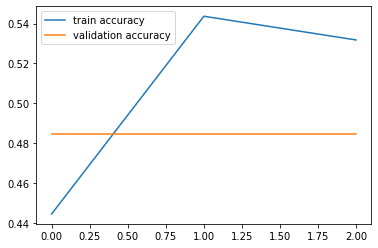

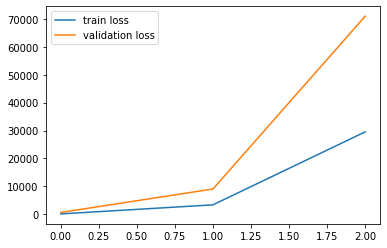

In [39]:
# Visualize the model's performance
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()